https://www.cpuheater.com/deep-learning/introduction-to-recurrent-neural-networks-in-pytorch/

In [2]:
import torch
from torch.autograd import Variable
import numpy as np
import pylab as pl
import torch.nn.init as init
import torch.optim as optim

import matplotlib.pyplot as plt

In [4]:
input_size = 7 
hidden_size = 6 
output_size = 1

seq_length = 100
start = 2
stop = 10
data_time_steps = np.linspace(start, stop, seq_length + 1)
data = np.sin(data_time_steps)
data.resize((seq_length + 1, 1))

# Prior to 0.4 we ad to wrap the tensor into a Variable. Now all the parameters are supported by the tensor class.
x = torch.tensor(data[:-1], dtype=torch.float, requires_grad=False)
y = torch.tensor(data[1:], dtype=torch.float, requires_grad=False)

We need to create two weight matrices, w1 of size (input_size, hidden_size) for input to hidden connections, and a w2 matrix of size (hidden_size, output_size) for hidden to output connection. Weights are initialized using a normal distribution with zero mean.

In [5]:
w1 = torch.ones(input_size, hidden_size, dtype=torch.float, requires_grad=True)
init.normal_(w1, 0.0, 0.4)
w2 = torch.ones(hidden_size, output_size, dtype=torch.float, requires_grad=True)
init.normal_(w2, 0.0, 0.3)

tensor([[ 0.0597],
        [-0.2742],
        [ 0.4228],
        [-0.1619],
        [-0.3437],
        [ 0.2400]], requires_grad=True)

We can now define forward method, it takes input vector, context_state vector and two weights matrices as arguments. We will create vector xh by concatenating input vector with the context_state vector. We perform dot product between the xh vector and weight matrix w1, then apply tanh function as nonlinearity, which works better with RNNs than sigmoid. Then we perform another dot product between new context_state and weight matrix w2. We want to predict continuous value, so we do not apply any nonlinearity at this stage.

Note that context_state vector will be used to populate context neurons at the next time step. That is why we return context_state vector along with the output of the network.

This is where the magic happens, context_state vector summarizes the history of the sequence it has seen so far.

In [6]:
def forward(input, context_state, w1, w2):
  xh = torch.cat((input, context_state), 1)
  context_state = torch.tanh(xh.mm(w1))
  out = context_state.mm(w2)
  return (out, context_state)

Training loop

The outer loop iterates over each epoch. Epoch is defined as one pass of all training data. At the beginning of each epoch, we need to initialize our context_state vector with zeros.
The inner loop runs through each element of the sequence. We run forward method to perform forward pass which returns prediction and context_state which will be used for next time step. Then we compute Mean Square Error (MSE),  which is a natural choice when we want to predict continuous values.  By running backward() method on the loss we calculating gradients, then we update the weights. We’re supposed to clear the gradients at each iteration by calling zero_() method otherwise gradients will be accumulated. The last thing we do is wrapping context_state vector in new Variable, to detach it from its history.


In [7]:
epochs = 300
lr = 0.05

for i in range(epochs):
  total_loss = 0
  context_state = torch.zeros((1, hidden_size), dtype=torch.float, requires_grad=True)
  
  for j in range(x.size(0)):
    input = x[j:(j+1)]
    target = y[j:(j+1)]
    (pred, context_state) = forward(input, context_state, w1, w2)
    loss = (pred - target).pow(2).sum()/2
    total_loss += loss
    loss.backward()
    w1.data -= lr * w1.grad.data
    w2.data -= lr * w2.grad.data
    w1.grad.data.zero_()
    w2.grad.data.zero_()
    # This is a trick to prevent: RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.
    context_state = Variable(context_state.data)
    
  if i % 10 == 0:
    print("Epoch: {} loss {}".format(i, total_loss.data[0]))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 loss 3.3712611198425293
Epoch: 10 loss 0.4043057858943939
Epoch: 20 loss 0.2654348909854889
Epoch: 30 loss 0.21690376102924347
Epoch: 40 loss 0.178419828414917
Epoch: 50 loss 0.14913225173950195
Epoch: 60 loss 0.12948115170001984
Epoch: 70 loss 0.11647197604179382
Epoch: 80 loss 0.10744905471801758
Epoch: 90 loss 0.10071122646331787
Epoch: 100 loss 0.09527729451656342
Epoch: 110 loss 0.09060629457235336
Epoch: 120 loss 0.08640582114458084
Epoch: 130 loss 0.08252028375864029
Epoch: 140 loss 0.07886599749326706
Epoch: 150 loss 0.07539840042591095
Epoch: 160 loss 0.07209297269582748
Epoch: 170 loss 0.0689350813627243
Epoch: 180 loss 0.0659162700176239
Epoch: 190 loss 0.06303092837333679
Epoch: 200 loss 0.0602743923664093
Epoch: 210 loss 0.057642605155706406
Epoch: 220 loss 0.05513143166899681
Epoch: 230 loss 0.052736904472112656
Epoch: 240 loss 0.050454430282115936
Epoch: 250 loss 0.04827997460961342
Epoch: 260 loss 0.046209849417209625
Epoch: 270 loss 0.044240258634090424
Epoch:

In [8]:
context_state = torch.zeros((1, hidden_size), dtype=torch.float, requires_grad=False)
predictions = []

for i in range(x.size(0)):
  input = x[i:i+1]
  (pred, context_state) = forward(input, context_state, w1, w2)
  context_state = context_state
  predictions.append(pred.data.numpy().ravel()[0])

100

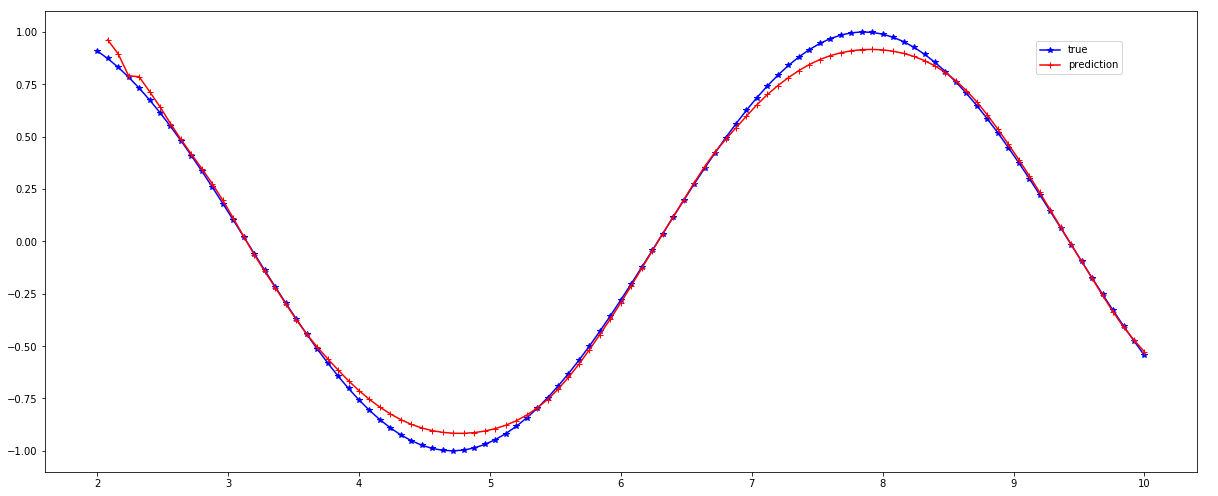

In [9]:
fig = plt.figure(figsize=(20,8))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(data_time_steps, data, marker="*", color="blue", label="true")
axes.plot(data_time_steps[1:], predictions, marker="+", color="red", label="prediction")
fig.legend(loc=(0.85,0.85))
len(predictions)
